Convolutional Dictionary Learning
=================================

This example demonstrating the use of [dictlrn.DictLearn](http://sporco.rtfd.org/en/latest/modules/sporco.dictlrn.dictlrn.html#sporco.dictlrn.dictlrn.DictLearn) to construct a dictionary learning algorithm with the flexibility of choosing the sparse coding and dictionary update classes. In this case they are [cbpdn.ConvBPDNJoint](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNJoint) and [ccmod.ConvCnstrMOD](http://sporco.rtfd.org/en/latest/modules/sporco.fista.ccmod.html#sporco.fista.ccmod.ConvCnstrMOD) respectively, so the resulting dictionary learning algorithm is not equivalent to [dictlrn.cbpdndl.ConvBPDNDictLearn](http://sporco.rtfd.org/en/latest/modules/sporco.dictlrn.cbpdndl.html#sporco.dictlrn.cbpdndl.ConvBPDNDictLearn). The example uses colour input images and a greyscale dictionary [[42]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-convolutional).

In [1]:
from __future__ import division
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.admm import cbpdn
from sporco.admm import ccmod
from sporco.dictlrn import dictlrn
from sporco import cnvrep
from sporco import util
from sporco import plot
plot.config_notebook_plotting()

Load training images.

In [2]:
exim = util.ExampleImages(scaled=True, zoom=0.5)
img1 = exim.image('barbara.png', idxexp=np.s_[10:522, 100:612])
img2 = exim.image('kodim23.png', idxexp=np.s_[:, 60:572])
img3 = exim.image('monarch.png', idxexp=np.s_[:, 160:672])
S = np.stack((img1, img2, img3), axis=3)

Highpass filter training images.

In [3]:
npd = 16
fltlmbd = 5
sl, sh = util.tikhonov_filter(S, fltlmbd, npd)

Construct initial dictionary.

In [4]:
np.random.seed(12345)
D0 = np.random.randn(8, 8, 64)

Construct object representing problem dimensions.

In [5]:
cri = cnvrep.CDU_ConvRepIndexing(D0.shape, sh)

Define X and D update options.

In [6]:
lmbda = 0.2
mu = 0.1
optx = cbpdn.ConvBPDNJoint.Options({'Verbose': False, 'MaxMainIter': 1,
            'rho': 50.0*lmbda + 0.5, 'AutoRho': {'Period': 10,
            'AutoScaling': False, 'RsdlRatio': 10.0, 'Scaling': 2.0,
            'RsdlTarget': 1.0}})
optd = ccmod.ConvCnstrMODOptions({'Verbose': False, 'MaxMainIter': 1,
            'rho': 10.0*cri.K, 'AutoRho': {'Period': 10, 'AutoScaling': False,
            'RsdlRatio': 10.0, 'Scaling': 2.0, 'RsdlTarget': 1.0}},
            method='ism')

Normalise dictionary according to dictionary Y update options.

In [7]:
D0n = cnvrep.Pcn(D0, D0.shape, cri.Nv, dimN=2, dimC=0, crp=True,
                 zm=optd['ZeroMean'])

Update D update options to include initial values for Y and U.

In [8]:
optd.update({'Y0': cnvrep.zpad(cnvrep.stdformD(D0n, cri.Cd, cri.M), cri.Nv),
             'U0': np.zeros(cri.shpD)})

Create X update object.

In [9]:
xstep = cbpdn.ConvBPDNJoint(D0n, sh, lmbda, mu, optx)

Create D update object.

In [10]:
dstep = ccmod.ConvCnstrMOD(None, sh, D0.shape, optd, method='ism')

Create DictLearn object and solve.

In [11]:
opt = dictlrn.DictLearn.Options({'Verbose': True, 'MaxMainIter': 100})
d = dictlrn.DictLearn(xstep, dstep, opt)
D1 = d.solve()
print("DictLearn solve time: %.2fs" % d.timer.elapsed('solve'), "\n")

Itn   FncX      r_X       s_X       ρ_X       FncD      r_D       s_D       ρ_D     
------------------------------------------------------------------------------------


   0  6.28e+03  1.00e+00  8.34e-05  1.05e+01  1.91e+03  1.75e-04  7.10e-02  3.00e+01


   1  4.85e+03  9.94e-01  2.17e-02  1.05e+01  1.86e+03  1.01e-01  2.44e-01  3.00e+01


   2  3.80e+03  9.17e-01  8.42e-02  1.05e+01  1.32e+03  2.65e-01  1.97e-01  3.00e+01


   3  3.60e+03  5.50e-01  1.46e-01  1.05e+01  9.77e+02  2.03e-01  1.55e-01  3.00e+01


   4  3.88e+03  3.65e-01  1.34e-01  1.05e+01  7.60e+02  1.86e-01  1.18e-01  3.00e+01


   5  3.70e+03  2.77e-01  1.15e-01  1.05e+01  6.06e+02  1.83e-01  1.02e-01  3.00e+01


   6  3.54e+03  2.39e-01  1.15e-01  1.05e+01  5.29e+02  1.71e-01  8.56e-02  3.00e+01


   7  3.31e+03  2.11e-01  1.05e-01  1.05e+01  5.06e+02  1.61e-01  7.13e-02  3.00e+01


   8  2.98e+03  1.78e-01  8.58e-02  1.05e+01  5.08e+02  1.42e-01  6.21e-02  3.00e+01


   9  2.73e+03  1.53e-01  7.33e-02  1.05e+01  5.17e+02  1.28e-01  5.80e-02  3.00e+01


  10  2.54e+03  1.37e-01  6.81e-02  1.05e+01  5.24e+02  1.18e-01  5.40e-02  3.00e+01


  11  2.41e+03  1.21e-01  5.98e-02  1.05e+01  5.31e+02  1.04e-01  4.70e-02  3.00e+01


  12  2.28e+03  1.04e-01  5.21e-02  1.05e+01  5.35e+02  9.11e-02  4.08e-02  3.00e+01


  13  2.16e+03  9.06e-02  4.76e-02  1.05e+01  5.34e+02  8.05e-02  3.58e-02  3.00e+01


  14  2.06e+03  7.97e-02  4.34e-02  1.05e+01  5.31e+02  7.17e-02  3.16e-02  3.00e+01


  15  1.98e+03  7.06e-02  4.00e-02  1.05e+01  5.28e+02  6.44e-02  2.83e-02  3.00e+01


  16  1.90e+03  6.34e-02  3.70e-02  1.05e+01  5.25e+02  5.83e-02  2.57e-02  3.00e+01


  17  1.84e+03  5.73e-02  3.42e-02  1.05e+01  5.24e+02  5.30e-02  2.36e-02  3.00e+01


  18  1.79e+03  5.23e-02  3.18e-02  1.05e+01  5.23e+02  4.89e-02  2.20e-02  3.00e+01


  19  1.74e+03  4.79e-02  2.97e-02  1.05e+01  5.22e+02  4.50e-02  2.04e-02  3.00e+01


  20  1.70e+03  4.40e-02  2.82e-02  1.05e+01  5.21e+02  4.20e-02  1.91e-02  3.00e+01


  21  1.66e+03  4.07e-02  2.65e-02  1.05e+01  5.20e+02  3.90e-02  1.77e-02  3.00e+01


  22  1.63e+03  3.77e-02  2.53e-02  1.05e+01  5.19e+02  3.68e-02  1.64e-02  3.00e+01


  23  1.60e+03  3.51e-02  2.41e-02  1.05e+01  5.17e+02  3.47e-02  1.53e-02  3.00e+01


  24  1.57e+03  3.27e-02  2.31e-02  1.05e+01  5.15e+02  3.30e-02  1.43e-02  3.00e+01


  25  1.55e+03  3.07e-02  2.22e-02  1.05e+01  5.14e+02  3.14e-02  1.35e-02  3.00e+01


  26  1.53e+03  2.90e-02  2.14e-02  1.05e+01  5.12e+02  3.00e-02  1.28e-02  3.00e+01


  27  1.51e+03  2.74e-02  2.05e-02  1.05e+01  5.11e+02  2.86e-02  1.21e-02  3.00e+01


  28  1.49e+03  2.59e-02  1.98e-02  1.05e+01  5.09e+02  2.75e-02  1.15e-02  3.00e+01


  29  1.47e+03  2.46e-02  1.91e-02  1.05e+01  5.08e+02  2.64e-02  1.09e-02  3.00e+01


  30  1.45e+03  2.34e-02  1.84e-02  1.05e+01  5.07e+02  2.54e-02  1.04e-02  3.00e+01


  31  1.44e+03  2.23e-02  1.79e-02  1.05e+01  5.06e+02  2.45e-02  1.00e-02  3.00e+01


  32  1.43e+03  2.14e-02  1.74e-02  1.05e+01  5.06e+02  2.38e-02  9.66e-03  3.00e+01


  33  1.42e+03  2.06e-02  1.69e-02  1.05e+01  5.05e+02  2.30e-02  9.34e-03  3.00e+01


  34  1.41e+03  1.99e-02  1.64e-02  1.05e+01  5.04e+02  2.23e-02  9.01e-03  3.00e+01


  35  1.40e+03  1.91e-02  1.59e-02  1.05e+01  5.04e+02  2.17e-02  8.71e-03  3.00e+01


  36  1.39e+03  1.84e-02  1.55e-02  1.05e+01  5.03e+02  2.11e-02  8.43e-03  3.00e+01


  37  1.38e+03  1.78e-02  1.51e-02  1.05e+01  5.02e+02  2.05e-02  8.14e-03  3.00e+01


  38  1.37e+03  1.72e-02  1.48e-02  1.05e+01  5.02e+02  2.00e-02  7.88e-03  3.00e+01


  39  1.36e+03  1.66e-02  1.44e-02  1.05e+01  5.01e+02  1.95e-02  7.63e-03  3.00e+01


  40  1.36e+03  1.61e-02  1.40e-02  1.05e+01  5.01e+02  1.90e-02  7.41e-03  3.00e+01


  41  1.35e+03  1.56e-02  1.37e-02  1.05e+01  5.00e+02  1.85e-02  7.22e-03  3.00e+01


  42  1.34e+03  1.51e-02  1.34e-02  1.05e+01  5.00e+02  1.81e-02  7.06e-03  3.00e+01


  43  1.34e+03  1.48e-02  1.31e-02  1.05e+01  4.99e+02  1.77e-02  6.91e-03  3.00e+01


  44  1.33e+03  1.44e-02  1.29e-02  1.05e+01  4.99e+02  1.74e-02  6.80e-03  3.00e+01


  45  1.33e+03  1.40e-02  1.26e-02  1.05e+01  4.99e+02  1.70e-02  6.68e-03  3.00e+01


  46  1.32e+03  1.37e-02  1.23e-02  1.05e+01  4.98e+02  1.67e-02  6.55e-03  3.00e+01


  47  1.32e+03  1.34e-02  1.21e-02  1.05e+01  4.98e+02  1.64e-02  6.44e-03  3.00e+01


  48  1.31e+03  1.31e-02  1.18e-02  1.05e+01  4.97e+02  1.61e-02  6.34e-03  3.00e+01


  49  1.31e+03  1.28e-02  1.16e-02  1.05e+01  4.97e+02  1.58e-02  6.26e-03  3.00e+01


  50  1.31e+03  1.26e-02  1.15e-02  1.05e+01  4.97e+02  1.55e-02  6.21e-03  3.00e+01


  51  1.30e+03  1.24e-02  1.13e-02  1.05e+01  4.97e+02  1.53e-02  6.17e-03  3.00e+01


  52  1.30e+03  1.22e-02  1.11e-02  1.05e+01  4.96e+02  1.51e-02  6.15e-03  3.00e+01


  53  1.30e+03  1.20e-02  1.09e-02  1.05e+01  4.96e+02  1.49e-02  6.13e-03  3.00e+01


  54  1.29e+03  1.19e-02  1.08e-02  1.05e+01  4.96e+02  1.47e-02  6.11e-03  3.00e+01


  55  1.29e+03  1.17e-02  1.06e-02  1.05e+01  4.95e+02  1.45e-02  6.07e-03  3.00e+01


  56  1.29e+03  1.15e-02  1.05e-02  1.05e+01  4.95e+02  1.43e-02  6.02e-03  3.00e+01


  57  1.29e+03  1.14e-02  1.04e-02  1.05e+01  4.95e+02  1.42e-02  5.95e-03  3.00e+01


  58  1.28e+03  1.12e-02  1.03e-02  1.05e+01  4.95e+02  1.41e-02  5.90e-03  3.00e+01


  59  1.28e+03  1.11e-02  1.02e-02  1.05e+01  4.94e+02  1.39e-02  5.81e-03  3.00e+01


  60  1.28e+03  1.09e-02  1.01e-02  1.05e+01  4.94e+02  1.37e-02  5.71e-03  3.00e+01


  61  1.28e+03  1.07e-02  9.97e-03  1.05e+01  4.94e+02  1.35e-02  5.59e-03  3.00e+01


  62  1.27e+03  1.05e-02  9.87e-03  1.05e+01  4.93e+02  1.34e-02  5.48e-03  3.00e+01


  63  1.27e+03  1.04e-02  9.75e-03  1.05e+01  4.93e+02  1.31e-02  5.34e-03  3.00e+01


  64  1.27e+03  1.02e-02  9.61e-03  1.05e+01  4.93e+02  1.29e-02  5.20e-03  3.00e+01


  65  1.27e+03  1.00e-02  9.47e-03  1.05e+01  4.93e+02  1.27e-02  5.03e-03  3.00e+01


  66  1.26e+03  9.78e-03  9.35e-03  1.05e+01  4.92e+02  1.25e-02  4.88e-03  3.00e+01


  67  1.26e+03  9.59e-03  9.20e-03  1.05e+01  4.92e+02  1.23e-02  4.72e-03  3.00e+01


  68  1.26e+03  9.37e-03  9.09e-03  1.05e+01  4.92e+02  1.21e-02  4.57e-03  3.00e+01


  69  1.25e+03  9.18e-03  8.96e-03  1.05e+01  4.92e+02  1.19e-02  4.43e-03  3.00e+01


  70  1.25e+03  8.98e-03  8.83e-03  1.05e+01  4.91e+02  1.17e-02  4.31e-03  3.00e+01


  71  1.25e+03  8.80e-03  8.69e-03  1.05e+01  4.91e+02  1.15e-02  4.18e-03  3.00e+01


  72  1.25e+03  8.60e-03  8.53e-03  1.05e+01  4.91e+02  1.13e-02  4.04e-03  3.00e+01


  73  1.24e+03  8.40e-03  8.38e-03  1.05e+01  4.91e+02  1.11e-02  3.89e-03  3.00e+01


  74  1.24e+03  8.16e-03  8.26e-03  1.05e+01  4.91e+02  1.08e-02  3.75e-03  3.00e+01


  75  1.24e+03  7.98e-03  8.11e-03  1.05e+01  4.91e+02  1.06e-02  3.62e-03  3.00e+01


  76  1.23e+03  7.75e-03  7.98e-03  1.05e+01  4.90e+02  1.04e-02  3.51e-03  3.00e+01


  77  1.23e+03  7.57e-03  7.84e-03  1.05e+01  4.90e+02  1.02e-02  3.40e-03  3.00e+01


  78  1.23e+03  7.38e-03  7.72e-03  1.05e+01  4.90e+02  1.00e-02  3.30e-03  3.00e+01


  79  1.23e+03  7.22e-03  7.57e-03  1.05e+01  4.90e+02  9.86e-03  3.21e-03  3.00e+01


  80  1.22e+03  7.05e-03  7.45e-03  1.05e+01  4.90e+02  9.68e-03  3.12e-03  3.00e+01


  81  1.22e+03  6.91e-03  7.33e-03  1.05e+01  4.90e+02  9.51e-03  3.03e-03  3.00e+01


  82  1.22e+03  6.76e-03  7.20e-03  1.05e+01  4.90e+02  9.34e-03  2.94e-03  3.00e+01


  83  1.22e+03  6.61e-03  7.10e-03  1.05e+01  4.90e+02  9.20e-03  2.87e-03  3.00e+01


  84  1.21e+03  6.48e-03  7.00e-03  1.05e+01  4.89e+02  9.05e-03  2.81e-03  3.00e+01


  85  1.21e+03  6.36e-03  6.89e-03  1.05e+01  4.89e+02  8.92e-03  2.75e-03  3.00e+01


  86  1.21e+03  6.22e-03  6.77e-03  1.05e+01  4.89e+02  8.75e-03  2.69e-03  3.00e+01


  87  1.21e+03  6.09e-03  6.67e-03  1.05e+01  4.89e+02  8.63e-03  2.63e-03  3.00e+01


  88  1.21e+03  5.98e-03  6.55e-03  1.05e+01  4.89e+02  8.49e-03  2.58e-03  3.00e+01


  89  1.20e+03  5.86e-03  6.44e-03  1.05e+01  4.89e+02  8.35e-03  2.53e-03  3.00e+01


  90  1.20e+03  5.74e-03  6.32e-03  1.05e+01  4.89e+02  8.20e-03  2.48e-03  3.00e+01


  91  1.20e+03  5.62e-03  6.21e-03  1.05e+01  4.89e+02  8.04e-03  2.43e-03  3.00e+01


  92  1.20e+03  5.50e-03  6.09e-03  1.05e+01  4.89e+02  7.90e-03  2.37e-03  3.00e+01


  93  1.20e+03  5.38e-03  5.97e-03  1.05e+01  4.89e+02  7.76e-03  2.30e-03  3.00e+01


  94  1.20e+03  5.27e-03  5.89e-03  1.05e+01  4.89e+02  7.65e-03  2.26e-03  3.00e+01


  95  1.19e+03  5.16e-03  5.81e-03  1.05e+01  4.88e+02  7.53e-03  2.22e-03  3.00e+01


  96  1.19e+03  5.07e-03  5.71e-03  1.05e+01  4.88e+02  7.41e-03  2.19e-03  3.00e+01


  97  1.19e+03  4.98e-03  5.62e-03  1.05e+01  4.88e+02  7.30e-03  2.16e-03  3.00e+01


  98  1.19e+03  4.90e-03  5.56e-03  1.05e+01  4.88e+02  7.21e-03  2.13e-03  3.00e+01


  99  1.19e+03  4.83e-03  5.48e-03  1.05e+01  4.88e+02  7.10e-03  2.11e-03  3.00e+01
------------------------------------------------------------------------------------
DictLearn solve time: 502.32s 



Display dictionaries.

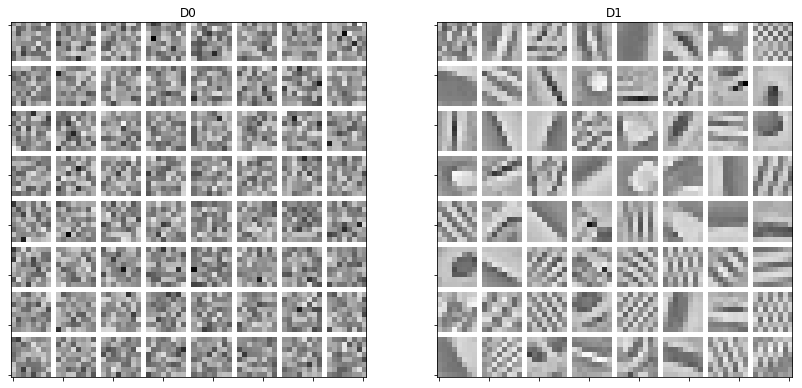

In [12]:
D1 = D1.squeeze()
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(util.tiledict(D0), title='D0', fig=fig)
plot.subplot(1, 2, 2)
plot.imview(util.tiledict(D1), title='D1', fig=fig)
fig.show()

Plot functional value and residuals.

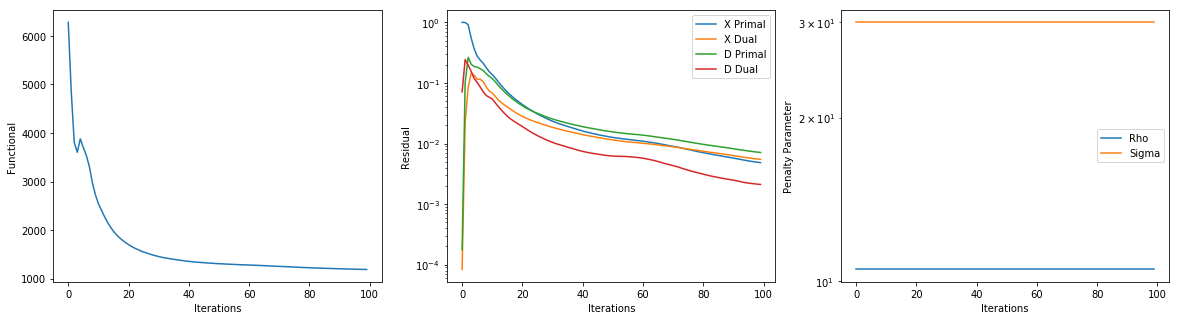

In [13]:
itsx = xstep.getitstat()
itsd = dstep.getitstat()
fig = plot.figure(figsize=(20, 5))
plot.subplot(1, 3, 1)
plot.plot(itsx.ObjFun, xlbl='Iterations', ylbl='Functional', fig=fig)
plot.subplot(1, 3, 2)
plot.plot(np.vstack((itsx.PrimalRsdl, itsx.DualRsdl, itsd.PrimalRsdl,
          itsd.DualRsdl)).T, ptyp='semilogy', xlbl='Iterations',
          ylbl='Residual', lgnd=['X Primal', 'X Dual', 'D Primal', 'D Dual'],
          fig=fig)
plot.subplot(1, 3, 3)
plot.plot(np.vstack((itsx.Rho, itsd.Rho)).T,  xlbl='Iterations',
          ylbl='Penalty Parameter', ptyp='semilogy', lgnd=['Rho', 'Sigma'],
          fig=fig)
fig.show()